# Enterprise Data Market Share Analysis

Using prepopulated, hypothetical data, I attempt to create an analysis that summarizes the performance of companies based on their respective descriptions, type of company, niche, location, and generated equity. 

The data is gathered by a company that primarily takes businesses and start up companies as clientele. This company will be referred to as "XYZ Inc" throughout the analysis.

In [41]:
import pandas as pd
import os, csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib.pyplot import figure
import operator

In [42]:
# Connect to the data file, and output a preview of the data

dataframe = pd.read_csv(os.path.join('enterprise_data.csv'))
dataframe.head(10)

,Company ID,Client Status,Vertical Description,Group Description,Deal Type,Business Group,Enhanced Life Stage,Enhanced Lifestage Reason,State,Equity Raised To Date
0,1010,Client,Cybersecurity,software,Later Stage VC,Tech,Mid/Late/Corp,Same,CA,"$36,322K"
1,1037,Former Client,FinTech,media,Later Stage VC,Tech,Mid/Late/Corp,PB - Later Stage <$50MM,FL,"$30,500K"
2,1037,Former Client,Life Sciences,healthcare devices and supplies,Later Stage VC,LifeSci,Large Corporate,PB - Later Stage >=$50MM,MA,"$72,651K"
3,1049,Former Client,Manufacturing,commercial products,Later Stage VC,Tech,Large Corporate,PB - Later Stage >=$50MM,CA,"$80,653K"
4,1053,Former Client,Mobile,software,Later Stage VC,Tech,Large Corporate,PB - Later Stage >=$50MM,VA,"$99,956K"
5,1056,Client,Big Data,software,Early Stage VC,Tech,Mid/Late/Corp,Moody - $5-75MM,PA,"$5,000K"
6,1059,Non-Client,Life Sciences,pharmaceuticals and biotechnology,Later Stage VC,LifeSci,Mid/Late/Corp,PB - Later Stage <$50MM,WA,"$21,409K"
7,1067,Client,Life Sciences,healthcare devices and supplies,Later Stage VC,LifeSci,Large Corporate,PB - Later Stage >=$50MM,MA,"$159,267K"
8,1078,Non-Client,E-Commerce,computer hardware,Later Stage VC,Tech,Mid/Late/Corp,PB - Later Stage <$50MM,IL,"$23,025K"
9,1087,Client,Mobile,healthcare technology systems,Later Stage VC,LifeSci,Large Corporate,PB - Later Stage >=$50MM,CA,"$114,642K"


## Part 0: Data Cleaning and Reformatting

Before getting into the analysis, I want to reformat the data so it is easier to read/understand, and that the values in "Equity Raised" are number values and not string values

In [43]:
# renaming columns and create master dataframe

df = [
    dataframe["Company ID"],
    dataframe["Client Status"],
    dataframe["Vertical Description"],
    dataframe["Group Description"],
    dataframe["Deal Type"],
    dataframe["Business Group"],
    dataframe["Enhanced Life Stage"],
    dataframe["Enhanced Lifestage Reason"],
    dataframe["State  "],
    dataframe["Equity Raised To Date "]
]

master = pd.DataFrame({
    "Company": df[0],
    "Type": df[5],
    "Niche": df[2],
    "Product Specialty": df[3],
    "Status": df[1],
    "Venture Type": df[4],
    "Current Stage": df[6],
    "Stage Value": df[7],
    "State": df[8],
    "Equity Raised": df[9],
})

# replace NaN with 0 if any
master = master.fillna(0)

master.head()

,Company,Type,Niche,Product Specialty,Status,Venture Type,Current Stage,Stage Value,State,Equity Raised
0,1010,Tech,Cybersecurity,software,Client,Later Stage VC,Mid/Late/Corp,Same,CA,"$36,322K"
1,1037,Tech,FinTech,media,Former Client,Later Stage VC,Mid/Late/Corp,PB - Later Stage <$50MM,FL,"$30,500K"
2,1037,LifeSci,Life Sciences,healthcare devices and supplies,Former Client,Later Stage VC,Large Corporate,PB - Later Stage >=$50MM,MA,"$72,651K"
3,1049,Tech,Manufacturing,commercial products,Former Client,Later Stage VC,Large Corporate,PB - Later Stage >=$50MM,CA,"$80,653K"
4,1053,Tech,Mobile,software,Former Client,Later Stage VC,Large Corporate,PB - Later Stage >=$50MM,VA,"$99,956K"


In [44]:
reformatted_equity = []

for i in range(len(master["Equity Raised"])):
    if isinstance(master["Equity Raised"][i], str):
        reformatted_equity.append(int(master["Equity Raised"][i].replace("$", "").replace(",", "").replace("K", "") + "000"))
    else:
        reformatted_equity.append(int(master["Equity Raised"][i]))
        
# we append a "000" to the end of the string equity value because the original values are in the thousands (k)

In [45]:
# replace the existing "Equity Raised" column with the reformatted version
master["Equity Raised"] = reformatted_equity
master.head()

,Company,Type,Niche,Product Specialty,Status,Venture Type,Current Stage,Stage Value,State,Equity Raised
0,1010,Tech,Cybersecurity,software,Client,Later Stage VC,Mid/Late/Corp,Same,CA,36322000
1,1037,Tech,FinTech,media,Former Client,Later Stage VC,Mid/Late/Corp,PB - Later Stage <$50MM,FL,30500000
2,1037,LifeSci,Life Sciences,healthcare devices and supplies,Former Client,Later Stage VC,Large Corporate,PB - Later Stage >=$50MM,MA,72651000
3,1049,Tech,Manufacturing,commercial products,Former Client,Later Stage VC,Large Corporate,PB - Later Stage >=$50MM,CA,80653000
4,1053,Tech,Mobile,software,Former Client,Later Stage VC,Large Corporate,PB - Later Stage >=$50MM,VA,99956000


In [46]:
# Show that the data type in Equity Raised is an integer
type(master["Equity Raised"][0])

numpy.int64

### This concludes the data cleaning.

## Part 1: Type (Business Group) Analysis

There are 3 main types of companies listed within the dataset: Life Science, Tech, and "Non". The "Non" group is referring to other types of companies not listed under Life Sciences or Technology industry. The purpose of this analysis is to discover the performance of an industry based on the amount of equity raised.

In [47]:
# get the total count of each type of company

total_types = master["Type"].count()
number_of_tech = master[master.Type == "Tech"].count()[0]
number_of_lifesci = master[master.Type == "LifeSci"].count()[0]
number_of_non = master[master.Type == "Non"].count()[0]
number_of_unlisted = master[master.Type == " "].count()[0]

# Validate that the number of each type equals the total number of entries in the dataset
print(total_types)
print([number_of_tech, number_of_lifesci, number_of_non, number_of_unlisted])
print(number_of_tech + number_of_lifesci + number_of_non + number_of_unlisted)

6695
[4907, 1588, 183, 17]
6695


In [48]:
# Create another dataframe using the information above

typesdf = pd.DataFrame({
    "Tech Companies": [number_of_tech / total_types],
    "Life Science Companies": [number_of_lifesci / total_types],
    "Other": [number_of_non / total_types],
    "Unlisted": [number_of_unlisted / total_types]
})
typesdf.head()

,Tech Companies,Life Science Companies,Other,Unlisted
0,0.732935,0.237192,0.027334,0.002539


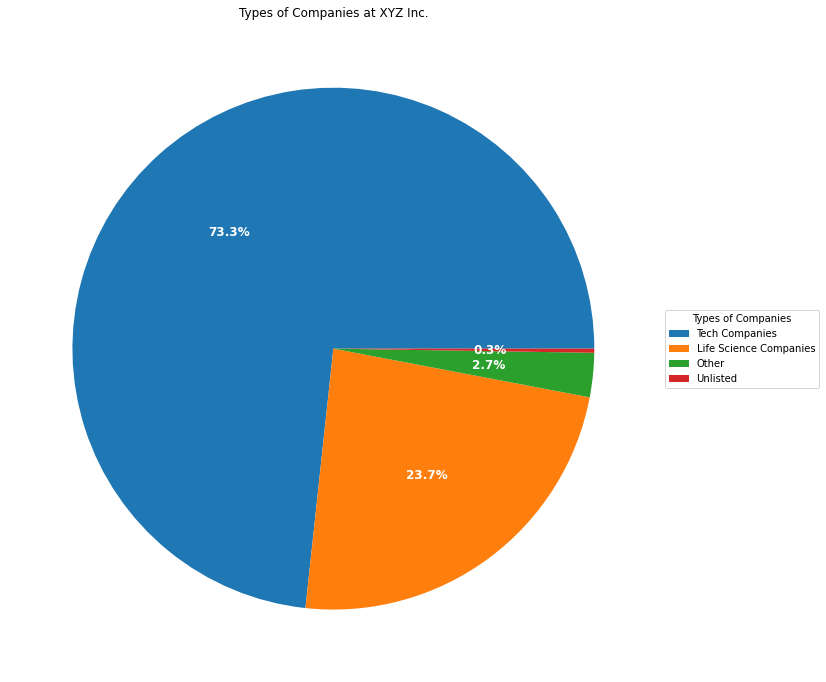

In [49]:
# Display a Pie Chart / Bar Chart to show the distribution of company types

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(aspect="equal"))
labels = ['Tech Companies', 'Life Science Companies', 'Other', 'Unlisted']
sizes = [typesdf["Tech Companies"][0], typesdf["Life Science Companies"][0], typesdf["Other"][0], typesdf["Unlisted"][0]]

wedges, texts, autotexts = ax.pie(sizes, autopct='%1.1f%%',
                                  textprops=dict(color="w"))

ax.legend(wedges, labels,
          title="Types of Companies",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Types of Companies at XYZ Inc.")

plt.show()

### The large majority of companies within XYZ Inc data is tech companies, followed by life science companies.  The 'Other' category is a list of companies do not have a specific type that can be categorized as Tech or Life Science. The majority of 'Unlisted' are companies that performed some sort of exit, and therefore are not listed in any specific type.

In [50]:
# Create a new dataframe to group by the amount of equity raised by each type of company
# Remember that each summ total is in (K). i.e. 1,000K == 1,000,000
master.groupby("Type")["Equity Raised"].sum()

# Please Note: The below values were validated using Excels pivot table function

Type
               19951000
LifeSci    109891693000
Non          7987639000
Tech       362861564000
Name: Equity Raised, dtype: int64

In [51]:
tech_equity = int(master.groupby("Type")["Equity Raised"].sum()[3])
lifesci_equity = int(master.groupby("Type")["Equity Raised"].sum()[1])
other_equity = int(master.groupby("Type")["Equity Raised"].sum()[2])
unlisted_equity = int(master.groupby("Type")["Equity Raised"].sum()[0])

In [52]:
# Create the equity totals dataframe grouped by Type
# Decided to remove the unlisted companies as the majority of them performed some sort of exit, and amounts
# to a very small portion of contributed value (outlier)

equity_totals_df = pd.DataFrame({
    "Equity Totals": master["Equity Raised"].sum(),
    "Tech Equity": [tech_equity],
    "Life Science Equity": [lifesci_equity],
    "Other Equity": [other_equity],
})

equity_totals_df.head()

,Equity Totals,Tech Equity,Life Science Equity,Other Equity
0,480760847000,362861564000,109891693000,7987639000


<ipython-input-53-4a1efc7794b7>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yaxis)


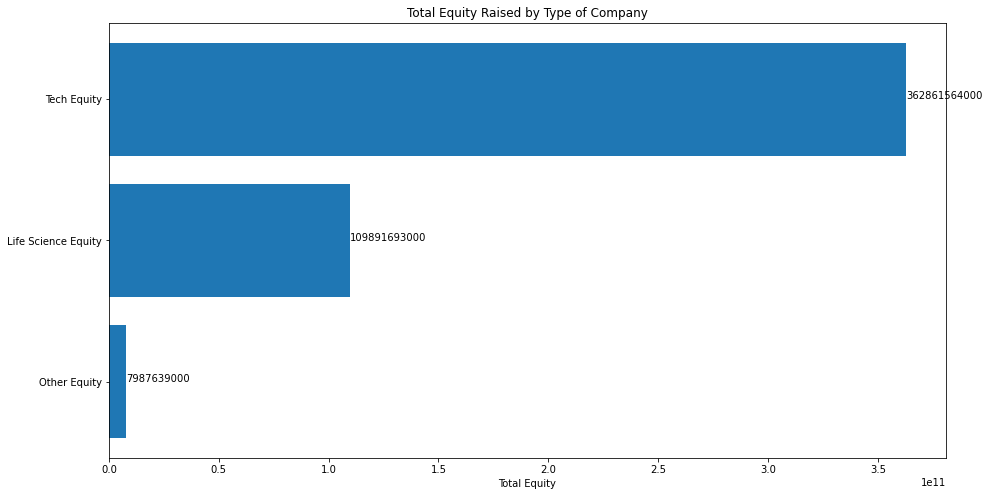

In [53]:
f, ax = plt.subplots(figsize=(15,8))

xaxis = [equity_totals_df["Tech Equity"][0], equity_totals_df["Life Science Equity"][0], equity_totals_df["Other Equity"][0]]
yaxis = ["Tech Equity", "Life Science Equity", "Other Equity"]

ax.barh(yaxis, xaxis)
ax.set_yticklabels(yaxis)
ax.invert_yaxis()
ax.set_xlabel("Total Equity")
ax.set_title('Total Equity Raised by Type of Company')

for index, value in enumerate(xaxis):
    plt.text(value, index, str(value))

plt.show()

### Result: 

Tech Companies returned the most total equity with a value of $362,861,564,000.00 USD while also contributing to over 73 percent of the total companies associated with XYZ Inc. 

Life Sciences follows with  $109,891,693,000.00 and 23.7 percent representation at XYZ Inc.

Companies not listed under Tech or Life Sciences accumulated $7,987,639,000.00 equity and represents 2.7 percent of all total companies at XYZ Inc.

## Part 2: Niche (Vertical Description) Analysis

Analyzing by type of company provides only a high level overview of the kind of success companies experience using products at XYZ Inc. We can dive deeper into the amount of equity raised by each company by analyzing the niches (or vertical description) that each company specializes in.

In [54]:
# Create the dataframe for Niche and Equity Raised

niche_df = pd.DataFrame({
    "Niche": master["Niche"],
    "Equity Raised": master["Equity Raised"]
})
niche_df.head()

,Niche,Equity Raised
0,Cybersecurity,36322000
1,FinTech,30500000
2,Life Sciences,72651000
3,Manufacturing,80653000
4,Mobile,99956000


In [55]:
# Create a dictionary that holds the total for each niche
niche_totals = {}

for i in range(len(master["Niche"])):
    if master["Niche"][i] not in niche_totals:
        niche_totals[master["Niche"][i]] = master["Equity Raised"][i]
    else:
        niche_totals[master["Niche"][i]] += master["Equity Raised"][i]

niche_totals = dict(sorted(niche_totals.items(), key=operator.itemgetter(1),reverse=True))
print(niche_totals)

{'Life Sciences': 80707592000, 'FinTech': 60422541000, 'E-Commerce': 59391726000, 'SaaS': 42607625000, 'Big Data': 36450938000, 'CleanTech': 21150681000, 'Manufacturing': 20885902000, 'Cybersecurity': 20049317000, 'Mobile': 19816999000, 0: 17193276000, 'TMT': 12762432000, 'HealthTech': 7907826000, 'Real Estate Technology': 7815897000, 'Robotics and Drones': 6729702000, 'Internet of Things': 6156245000, 'Space Technology': 5680804000, 'EdTech': 4818933000, 'Wearables & Quantified Self': 4541761000, 'Autonomous cars': 4516372000, 'eSports': 4316324000, 'FoodTech': 4018047000, 'HR Tech': 3424118000, 'LOHAS & Wellness': 3335327000, 'Restaurant Technology': 3309625000, 'Cannabis': 3028469000, 'AdTech': 2607285000, 'AgTech': 2114208000, 'Industrials': 2013144000, 'Advanced Manufacturing': 1872321000, 'Artificial Intelligence & Machine Learning': 1741903000, 'Construction Technology': 1676681000, 'Digital Health': 1259506000, 'Virtual Reality': 1085126000, 'Marketing Tech': 1064754000, 'Nanot

In [56]:
# Convert the values in the dictionary into a dataframe

niche_equity_df = pd.DataFrame(niche_totals.items(), columns=['Niche', 'Equity Raised'])
niche_equity_df.head()

,Niche,Equity Raised
0,Life Sciences,80707592000
1,FinTech,60422541000
2,E-Commerce,59391726000
3,SaaS,42607625000
4,Big Data,36450938000


In [76]:
# store all values for each column into a list to prep the chart
# reduce size of chart to top ten niches

niche_equity_df = niche_equity_df.head(10)

niche_titles, niche_equities = [], []
for i in range(len(niche_equity_df["Niche"])):
    if niche_equity_df["Niche"][i] != 0:
        niche_titles.append(niche_equity_df["Niche"][i])
        niche_equities.append(niche_equity_df["Equity Raised"][i])

<ipython-input-80-e0a9faa99c3f>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yaxis)


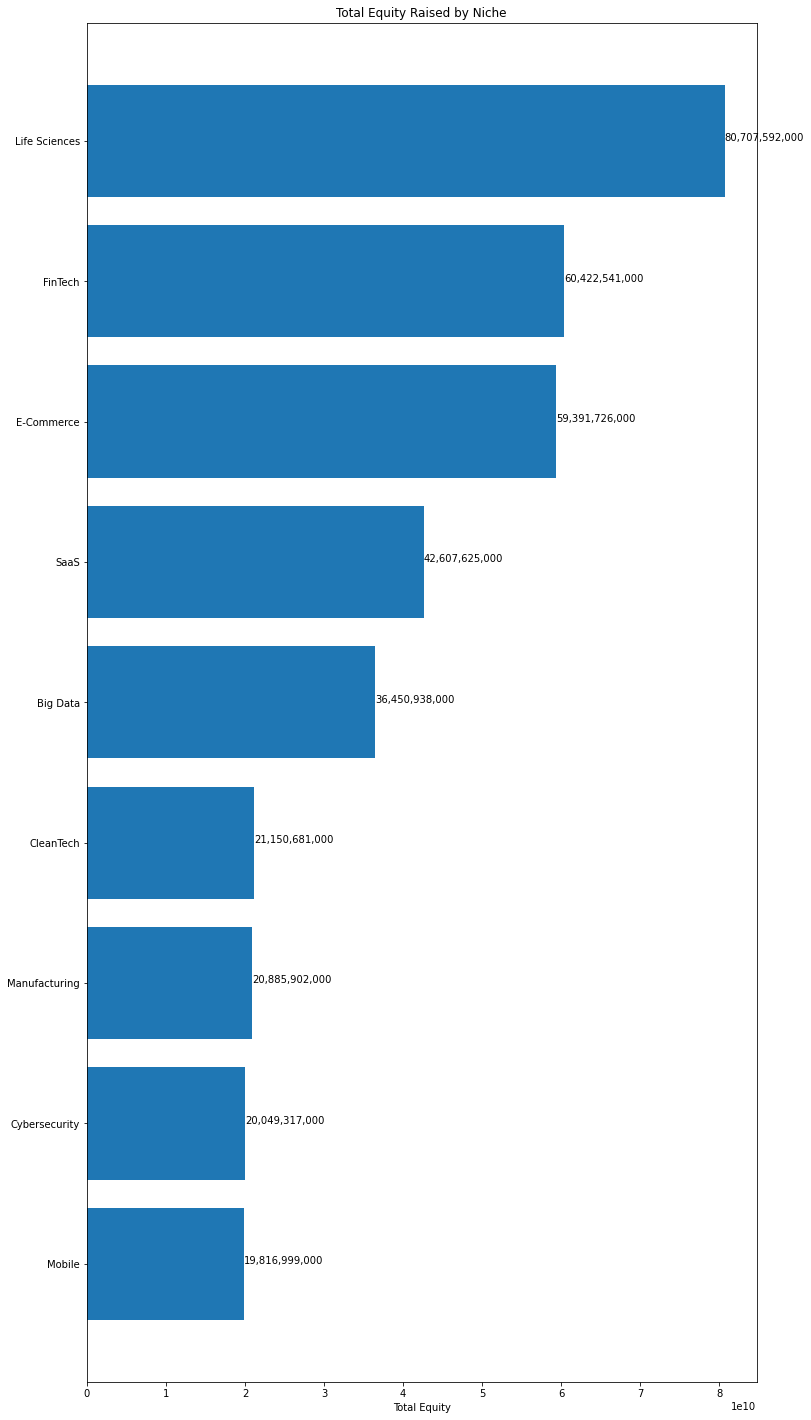

In [80]:
f, ax = plt.subplots(figsize=(12,25))

xaxis = niche_equities
yaxis = niche_titles

ax.barh(yaxis, xaxis)
ax.set_yticklabels(yaxis)
ax.invert_yaxis()
ax.set_xlabel("Total Equity")
ax.set_title('Total Equity Raised by Niche')

for index, value in enumerate(xaxis):
    plt.text(value, index, str(f'{value:,}'))

plt.show()

### Result:

Companies with a niche in Life Sciences, Fintech, and E-commerce generated equity that towered over the other niches. Just Life Sciences alone raised equity that is greater than the combined total of companies listed below "Big Data" (referring to the chart above). 

## Part 3: Product (Group Description) Analysis

So we've taken a look at the higher level overview of which types and niches are more successful than others at raising equity. However, both analyses are quite broad and may not have reliable results. I want to analyze the kinds of products sold by each company to get a better gauge of what PRODUCTS sold are popular to the consumers.

In [59]:
# display the kinds of products sold by each company

master["Product Specialty"].value_counts()

software                                2568
pharmaceuticals and biotechnology        758
healthcare devices and supplies          488
commercial services                      438
healthcare technology systems            331
consumer non-durables                    260
commercial products                      195
consumer durables                        166
media                                    164
healthcare services                      150
computer hardware                        146
services (non-financial)                 138
retail                                   105
other financial services                  96
apparel and accessories                   68
transportation                            61
communications and networking             60
it services                               58
restaurants, hotels and leisure           53
energy services                           51
energy equipment                          50
agriculture                               48
semiconduc

In [60]:
# create a dataframe using Product Specialty and Equity Raised.

product_spec = {}
for i in range(len(master["Product Specialty"])):
    if master["Product Specialty"][i] != "0" and master["Product Specialty"][i] not in product_spec:
        product_spec[master["Product Specialty"][i]] = master["Equity Raised"][i]
    else:
        product_spec[master["Product Specialty"][i]] += master["Equity Raised"][i]
        
product_spec = dict(sorted(product_spec.items(), key=operator.itemgetter(1),reverse=True))

product_df = pd.DataFrame(product_spec.items(), columns=['Product', 'Equity Raised'])
product_df.head(20)

,Product,Equity Raised
0,software,141649029000
1,pharmaceuticals and biotechnology,69294903000
2,transportation,50457567000
3,consumer durables,27044716000
4,healthcare devices and supplies,23934168000
5,commercial services,21668619000
6,healthcare technology systems,15716322000
7,other financial services,14287691000
8,commercial products,12599710000
9,retail,12527926000


In [69]:
# lets remove the products that have little affect on the overall Equity Raised as we want to find the most suxxessful product
top_ten_products = product_df.head(10)

# Store the product names and values into lists to create the chart
product_name, prod_equity = [], []

for i in range(len(top_ten_products["Product"])):
    product_name.append(top_ten_products["Product"][i])
    prod_equity.append(top_ten_products["Equity Raised"][i])

<ipython-input-75-af51fca41963>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yaxis)


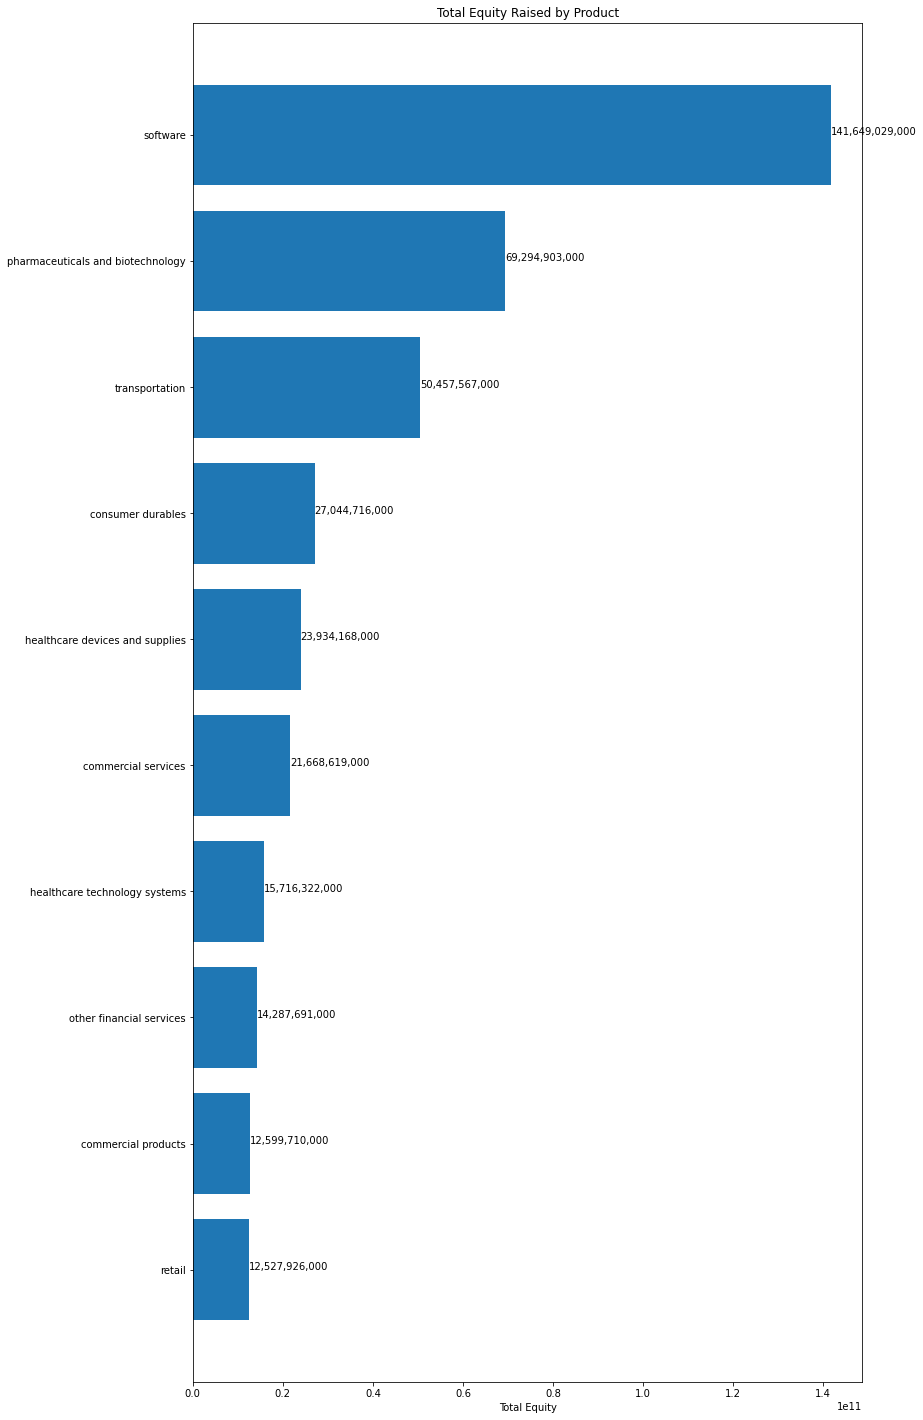

In [75]:
f, ax = plt.subplots(figsize=(12,25))

xaxis = prod_equity
yaxis = product_name

ax.barh(yaxis, xaxis)
ax.set_yticklabels(yaxis)
ax.invert_yaxis()
ax.set_xlabel("Total Equity")
ax.set_title('Total Equity Raised by Product')

for index, value in enumerate(xaxis):
    plt.text(value, index, str(f'{value:,}'))

plt.show()

In [63]:
print(f'{product_df["Equity Raised"][0]:,}')

141,649,029,000
